# Elo Bidimensional aplicado ao Tênis

Primeiro vamos rodar algumas definições de funções e import's

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

%run data_functions.py
%run model_functions.py

Dentre as funções definidas acimas podemos ilustrar algumas mais básicas, como a que calcula a probabilidade de um jogador A vencer um jogador B no confronto entre eles e a que calcula a verossimilhança dos resultados de alguns confrontos dados os parâmetros dos jogadores.

In [2]:
player1 = [   1,          0]
player2 = [-0.5,  sqrt(3)/2]
player3 = [-0.5, -sqrt(3)/2]

print('Entre player1 e player2 temos', find_probability(player1, player2), 'para vitória do player1')
print('Entre player2 e player3 temos', find_probability(player2, player3), 'para vitória do player2')
print('Entre player3 e player1 temos', find_probability(player3, player1), 'para vitória do player3')

results = [[0, 1], [1, 2], [2, 1]]
players = [1, 0, -0.5, sqrt(3)/2, -0.5, -sqrt(3)/2]

print('Verossimilhança:', likelihood(players, results))

Entre player1 e player2 temos 0.2960820052793571 para vitória do player1
Entre player2 e player3 temos 0.2960820052793571 para vitória do player2
Entre player3 e player1 temos 0.2960820052793571 para vitória do player3
Verossimilhança: 2.785331050711237


Agora podemos começar a trabalhar com os dados que temos em mãos. Para situar, temos os seguintes parâmetros:

`path` é o caminho da pasta em que se encontram os arquivos de jogos de cada ano;
`files` é uma lista com os os arquivos de jogos, junto do caminho;
`rank` é o caminho do arquivo que contém o ranking atual;
`top` é a quantidade de jogadores que iremos analisar.

A função `catch_all_games` recebe os parâmetros acima e os parâmetros `surface` e `sets`, os quais foram definidos, por default, a 'Hard' e 3, respectivamente, retornando um dataframe com os jogos entre os `top` jogadores do ranking.

Já a função `catch_data` recebe o dataframe anterior e retorna uma lista `players_id`, onde cada elemento é a ID original do jogador, a qual foi substituida por seu índice dessa lista, uma outra lista `players`, com parâmetros iniciais para os jogadores (parâmetros aleatórios para um palpite inicial na minimização da log-verossimilhança negativa), uma lista `results` com os resultados dos jogos entre os jogadores, uma lista `bounds` com os limites de cada parâmetro para cada jogador, que no caso estão no intervalo $(0, \infty)$ e $(-\infty, \infty)$, respectivamente e, por fim, uma amostra dos dados, a qual se refere a porção dos dados utilizadas como treino do modelo.

In [3]:
# define parameters
top = 100
first_year = 2018
last_year = 2020
surface = 'Hard'
sets = 3

# processing data
path = '../tennis_atp/'
files = [path + 'atp_matches_' + str(year) + '.csv' for year in range(first_year, last_year + 1)]
rank = path + 'atp_rankings_current.csv'

games = catch_all_games(files, rank, top, surface = surface, sets = sets)
players_id, players, results, bounds, games = catch_data(games, True)

C:\Users\igorm\.julia\conda\3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Agora, usando os dados já coletados a gente minimiza os parâmetros.

In [4]:
optimal_parameter = minimize(likelihood,
                             players,
                             args = results,
                             method = 'SLSQP',
                             bounds = bounds,
                             options = {'maxiter' : 10000})

optimal_parameter

     fun: 367.07428403970823
     jac: array([-1.12915039e-03,  3.79562378e-03, -5.39087677e+00,  2.31080017e+01,
        4.07825470e+00, -5.35973358e+00,  6.62269592e-01,  1.22562027e+00,
       -6.16455078e-03,  3.77120972e-02,  6.84623718e-01, -3.62904358e+00,
       -1.52587891e-04,  3.81469727e-06,  4.59572971e+02, -1.48071671e+00,
       -4.03422737e+01, -2.34751015e+01,  8.63329315e+00, -1.87050247e+00,
       -9.49557495e+00, -4.22832184e+01,  9.15527344e-05,  9.19342041e-04,
        1.65125694e+01, -5.41884384e+01, -6.10351562e-04,  1.90734863e-03,
        9.39139374e+02, -4.42070007e-01, -3.81469727e-06,  2.67028809e-05,
       -4.37927246e-03,  1.28555298e-03, -2.04569359e+01, -5.28513222e+01,
        1.96247292e+01, -4.00388336e+00,  8.20427586e+02,  2.40207291e+00,
       -1.38473511e-03, -2.17437744e-04,  1.57928467e-03, -5.72204590e-05,
       -9.13895798e+00, -1.47139473e+01,  4.03976440e-03, -2.94799805e-02,
        3.05175781e-05, -3.24249268e-04,  0.00000000e+00,  0.

Tendo encontrado os parâmetros que minimizam a log-verossimilhança negativa para os jogos de treino, podemos ver os resultados para os jogos de testagem:

In [5]:
players = []
for i in range(int(len(optimal_parameter.x)/2)):
    players.append([optimal_parameter.x[2*i], optimal_parameter.x[2*i + 1]])

results_test, games_test = catch_data(games, False)
likelihood(players, results_test)

167.32910642334582

Note que a log-verossimilhança negativa para os jogos de teste é inferior que para os dados de treino, o que pode nos levar a inferir que nosso modelo está no caminho certo

In [6]:
optimal_parameter.fun

367.07428403970823

### Um teste de linearidade

Para todo trio de jogadores $A$, $B$ e $C$ iremos calcular as probabilidades de $A$ ganhar de $B$, $A$ ganhar de $C$ e $B$ ganhar de $C$ e analisaremos a linearidade.

In [7]:
linearity = 0
fail = 0

for i in range(len(players) - 2):
    for j in range(i + 1, len(players) - 1):
        for k in range(j + 1, len(players)):
            AB = find_probability(players[i], players[j])
            AC = find_probability(players[i], players[k])
            BC = find_probability(players[j], players[k])
            if AB > 0.5 and BC > 0.5 and AC < 0.5:
                # cycle A beating B, B beating C and C beating A
                fail += 1
                # print('Player', i, 'beat', j, 'player', j, 'beat', k, 'and player', k, 'beat', i)
            elif AB < 0.5 and BC < 0.5 and AC > 0.5:
                # cycle B beating A, C beating B and A beating C
                fail += 1
                # print('Player', j, 'beat', i, 'player', k, 'beat', j, 'and player', i, 'beat', k)
            else:
                linearity += 1

In [8]:
print('Ratio linearity/total:', linearity/(linearity + fail))

Ratio linearity/total: 0.951638837353123


Onde podemos ver que, a priori, o tênis apresenta linearidade.

### Outro teste de linearidade

Agora analisaremos para todos os posíveis ciclos de jogadores.

Para tanto, primeiro iremos criar um grafo direcionado onde cada vértice representa um jogador e uma aresta do jogador $A$ para o jogador $B$ indica que $A$ vence $B$.

In [9]:
# define parameters
top = 20
first_year = 2018
last_year = 2020
surface = 'Hard'
sets = 3

# processing data
path = '../tennis_atp/'
files = [path + 'atp_matches_' + str(year) + '.csv' for year in range(first_year, last_year + 1)]
rank = path + 'atp_rankings_current.csv'

games = catch_all_games(files, rank, top, surface = surface, sets = sets)
players_id, players, results, bounds, games = catch_data(games, True)

# optmizing players' parameters
optimal_parameter = minimize(likelihood,
                             players,
                             args = results,
                             method = 'SLSQP',
                             bounds = bounds,
                             options = {'maxiter' : 10000})

players = []
for i in range(int(len(optimal_parameter.x)/2)):
    players.append([optimal_parameter.x[2*i], optimal_parameter.x[2*i + 1]])

results_test, games_test = catch_data(games, False)
likelihood(players, results_test)

21.157374745128433

In [10]:
optimal_parameter.fun

40.12678732289912

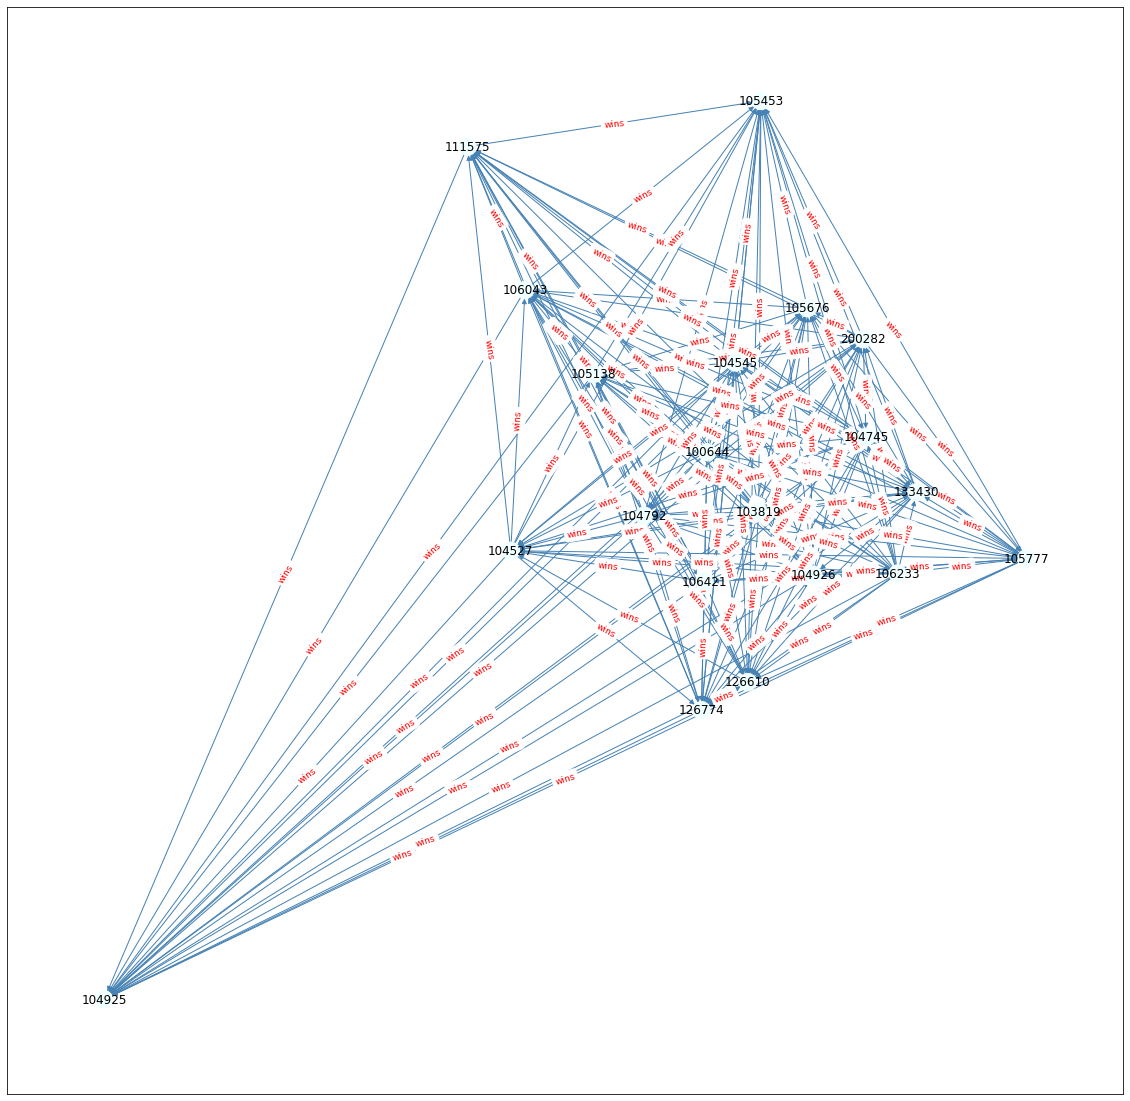

In [11]:
G = nx.DiGraph()
M = [[0 for i in range(len(players))] for j in range(len(players))]

for athlete in players_id:
    G.add_node(athlete, color = 'azure')

for i in range(len(players)):
    for j in range(i + 1, len(players)):
        prob = find_probability(players[i], players[j])
        if prob == 0.5:
            M[i][j] = 1
            M[j][i] = 1
            G.add_edge(players_id[i], players_id[j],
                       color = 'steelblue',
                       relation = 'wins')
            G.add_edge(players_id[j], players_id[i],
                       color = 'steelblue',
                       relation = 'wins')
        elif prob < 0.5:
            M[j][i] = 1
            G.add_edge(players_id[j], players_id[i],
                       color = 'steelblue',
                       relation = 'wins')
        else:
            M[i][j] = 1
            G.add_edge(players_id[i], players_id[j],
                       color = 'steelblue',
                       relation = 'wins')
            
fig, ax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(G, scale=1)
nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels = nx.get_edge_attributes(G,'relation'),
                             label_pos = 0.5, 
                             font_size = 9, 
                             font_color = 'red', 
                             font_family = 'sans-serif', 
                             font_weight = 'normal', 
                             alpha = 1.0, 
                             bbox = None, 
                             ax = ax, 
                             rotate = True)

nx.draw_networkx(G,
                 pos = pos,
                 ax = ax,
                 node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                 edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],)

plt.show()

Feito tal grafo, iremos calcular quantos são os possíveis ciclos e quantos ciclos existem no grafo.

#### Ideia principal:

Imagine que são $n$ jogadores. Vamos ver de quantas formas podemos fazer um ciclo de $k$ jogadores. Em primeiro lugar, podemos escolher os jogadores desse ciclo de $C_{n, k}$ formas. Feito isso, podemos formar esse ciclo de $(k - 1)!$ formas, assim, temos ao todo $\dfrac{n!}{k \cdot (n - k)!}$ ciclos de $k$ jogadores.

Com $k$ variando de $3$ a $n$, temos:

In [12]:
possible_cycles = 0
for i in range(3, len(players) + 1):
    possible_cycles += factorial(len(players)) / (i * factorial(len(players) - i))
    
possible_cycles

3.490966647286231e+17

Por outro lado, podemos contar a quantidade de ciclos que realmente existe no nosso grafo:

In [13]:
total_cycles = len(list(nx.simple_cycles(G)))
total_cycles

2141153

Dessa forma, temos que a razão de ciclos para a quantidade máxima de ciclos é:

In [14]:
total_cycles/possible_cycles

6.1334100732943575e-12

### Outro teste (apenas um rascunho)

A ideia é seguir a mesma abordagem que a anterior, mas utilizando matriz de adjacência (acho que o runtime será maior que o do algoritmo anterior, pois multiplicação de matriz é $O(n^2)$).

In [15]:
# define parameters
top = 10
first_year = 2018
last_year = 2020
surface = 'Hard'
sets = 3

# processing data
path = '../tennis_atp/'
files = [path + 'atp_matches_' + str(year) + '.csv' for year in range(first_year, last_year + 1)]
rank = path + 'atp_rankings_current.csv'

games = catch_all_games(files, rank, top, surface = surface, sets = sets)
players_id, players, results, bounds, games = catch_data(games, True)

# optmizing players' parameters
optimal_parameter = minimize(likelihood,
                             players,
                             args = results,
                             method = 'SLSQP',
                             bounds = bounds,
                             options = {'maxiter' : 10000})

players = []
for i in range(int(len(optimal_parameter.x)/2)):
    players.append([optimal_parameter.x[2*i], optimal_parameter.x[2*i + 1]])

results_test, games_test = catch_data(games, False)
likelihood(players, results_test)

8.339516276630818

In [16]:
optimal_parameter.fun

15.269294577700105

In [17]:
N = np.dot(M, M)
total_cycles = 0

for i in range(len(players)):
    total_cycles += N[i][i]
        
for i in range(len(players) - 2):
    N = np.dot(N, M)
    for i in range(len(players)):
        total_cycles += N[i][i]

total_cycles

14266685

In [18]:
def partition(largest, *rest):
    '''
    find all partitions of a number
    '''
    result = []
    result.append([largest, *rest])
    min = rest[0] if rest else 1
    max = largest // 2
    for n in range(min, max+1):
        partial = partition(largest-n, n, *rest)
        for item in partial:
            result.append(item)
    
    return result

result = partition(10, 3)
result

[[10, 3], [7, 3, 3], [4, 3, 3, 3], [6, 4, 3], [5, 5, 3]]

In [19]:
def counting(sequence):
    '''
    receives a sequence of numbers and returns
    a list with the count of how many times a
    number appears in that sequence
    '''
    result = [0 for i in range(max(sequence))]
    for number in sequence:
        result[number - 1] += 1
    
    return result

In [20]:
counting(result[-1])

[0, 0, 1, 0, 2]

In [21]:
total_cycles = [[0 for i in range(len(players))] for j in range(len(players))]
N = np.dot(M, M)

for player in range(len(players)):
    total_cycles[1][player] += N[player][player]
        
for len_cycle in range(2, len(players)):
    N = np.dot(N, M)
    numerator = factorial(len_cycle + 1)
    partitions = partition(len_cycle + 1, 3)
    for item in partitions:
        item.pop(-1)
        count = counting(item)
        denominator = 1
        for value in count:
            denominator *= factorial(value)
        
        permutations = numerator/denominator
        for player in range(len(players)):
            sub = 0
            for value in count:
                ind_cycle = count.index(value)
                sub += total_cycles[ind_cycle][player] ** value
            
            total_cycles[len_cycle][player] += N[player][player] - sub * permutations
            
#     for player in range(len(players)):
#         total_cycles[len_cycle][player] += N[player][player]

soma = 0
for item in total_cycles:
    for subitem in item:
        soma += subitem

for line in total_cycles:
    print(line)
    
soma

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-8.0, 7.0, 1.0, -5.0, 4.0, 4.0, 4.0, -12.0, 2.0, 10.0]
[-48.0, 26.0, -2.0, -39.0, 21.0, 21.0, 21.0, -72.0, -2.0, 42.0]
[-380.0, -135.0, -242.0, -363.0, -180.0, -180.0, -180.0, -480.0, -237.0, -85.0]
[-26310.0, -17986.0, -1992.0, -12040.0, -6720.0, -6720.0, -6720.0, -56160.0, -2876.0, -35748.0]
[46462.0, -86168.0, -33248.0, 18044.0, -58506.0, -58506.0, -58506.0, 80640.0, -42544.0, -112538.0]
[-46218924.0, -14469855.0, -495318.0, -30662244.0, -9509901.0, -9509901.0, -9509901.0, -104005440.0, -571779.0, -36617244.0]
[66373492.0, -49010096.0, -4039484.0, 34340076.0, -26485548.0, -26485548.0, -26485548.0, 159909120.0, -5150572.0, -102345576.0]
[-261695959070.0, -33510663650.0, -106319753255.0, -238810355855.0, -59103802645.0, -59103802645.0, -59103802645.0, -417634963200.0, -101986684320.0, -13810409350.0]


-1351321627455.0

In [22]:
a = partition(10, 3)
for item in a:
    item.pop(-1)
    
a

[[10], [7, 3], [4, 3, 3], [6, 4], [5, 5]]